In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

In [39]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [40]:
customer_transaction = transactions.groupby('CustomerID').agg(
    total_transactions=("TransactionID", 'count'),
    total_quantity=('Quantity', 'sum'),
    total_revenue=('TotalValue', 'sum'),
    avg_transaction_value=("TotalValue", 'mean'),
    product_variance=("ProductID", 'nunique')
).reset_index()

In [41]:
data = pd.merge(customers, customer_transaction, on="CustomerID", how='inner')
encoder = OneHotEncoder()
encoded_region = encoder.fit_transform(data[['Region']]).toarray()
encoded_region_df = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(['Region']))

In [42]:
data = pd.concat([data, encoded_region_df], axis=1)
data.drop(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], axis=1, inplace=True)

In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
n_features = scaled_data.shape[1]
pca = PCA(n_components=min(10, n_features))  # Ensure n_components does not exceed n_features
pca_data = pca.fit_transform(scaled_data)


In [44]:
db_scores_2 = []
silhouette_scores = []
calinski_harabasz_scores_list = []  # Renamed to avoid conflict

cluster_range = range(2, 11)
for i in cluster_range:
    hierarchical_cluster = AgglomerativeClustering(n_clusters=i, linkage='ward')
    cluster_labels = hierarchical_cluster.fit_predict(scaled_data)
    db_score = davies_bouldin_score(scaled_data, cluster_labels)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    calinski_harabasz_avg = calinski_harabasz_score(scaled_data, cluster_labels)
    db_scores_2.append(db_score)
    silhouette_scores.append(silhouette_avg)
    calinski_harabasz_scores_list.append(calinski_harabasz_avg)


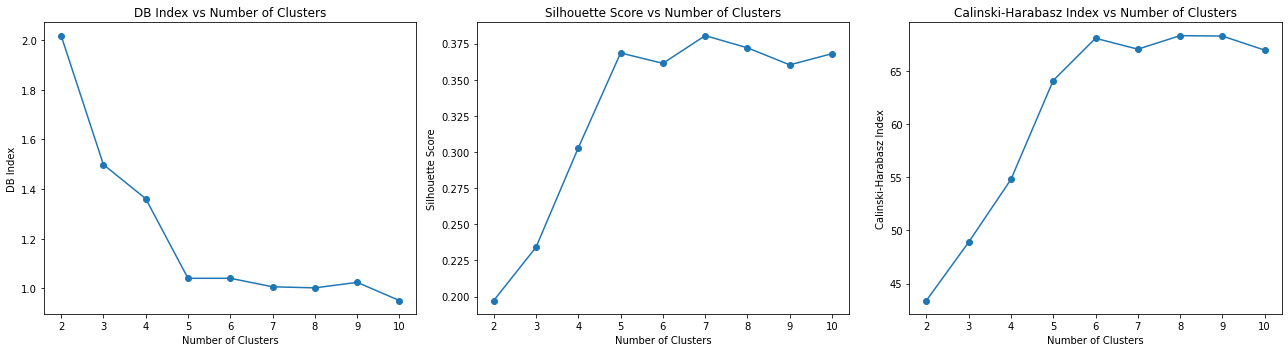

In [45]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(cluster_range, db_scores_2, marker='o')
plt.title("DB Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")

plt.subplot(1, 3, 2)
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.subplot(1, 3, 3)
plt.plot(cluster_range, calinski_harabasz_scores_list, marker='o')
plt.title("Calinski-Harabasz Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Index")

plt.tight_layout()
plt.show()

print(f"Cluster range : {cluster_range}")
print(f"")

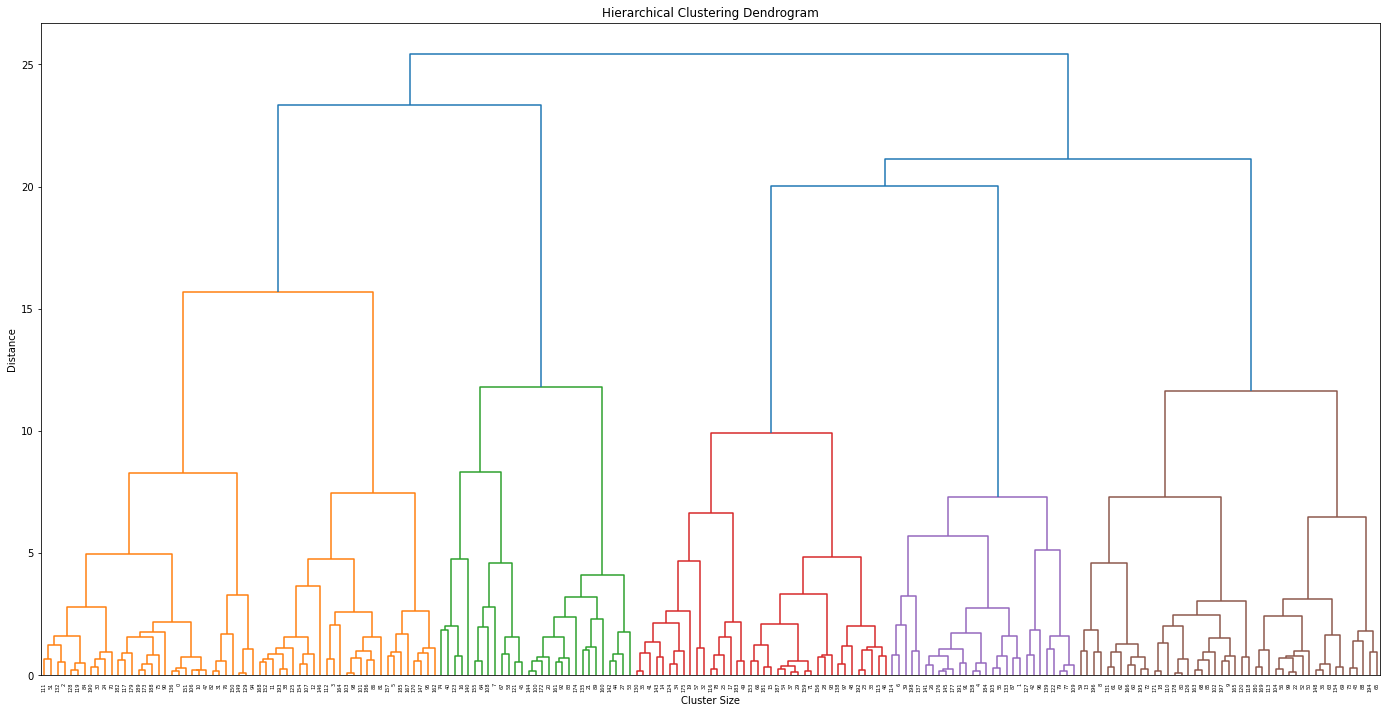

In [47]:
linked = linkage(pca_data, 'ward')
plt.figure(figsize=(24, 12))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()


In [49]:
optimal_clusters = cluster_range[np.argmin(db_scores_2)]
hierarchical_cluster = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
cluster_labels = hierarchical_cluster.fit_predict(scaled_data)
data['Cluster'] = cluster_labels


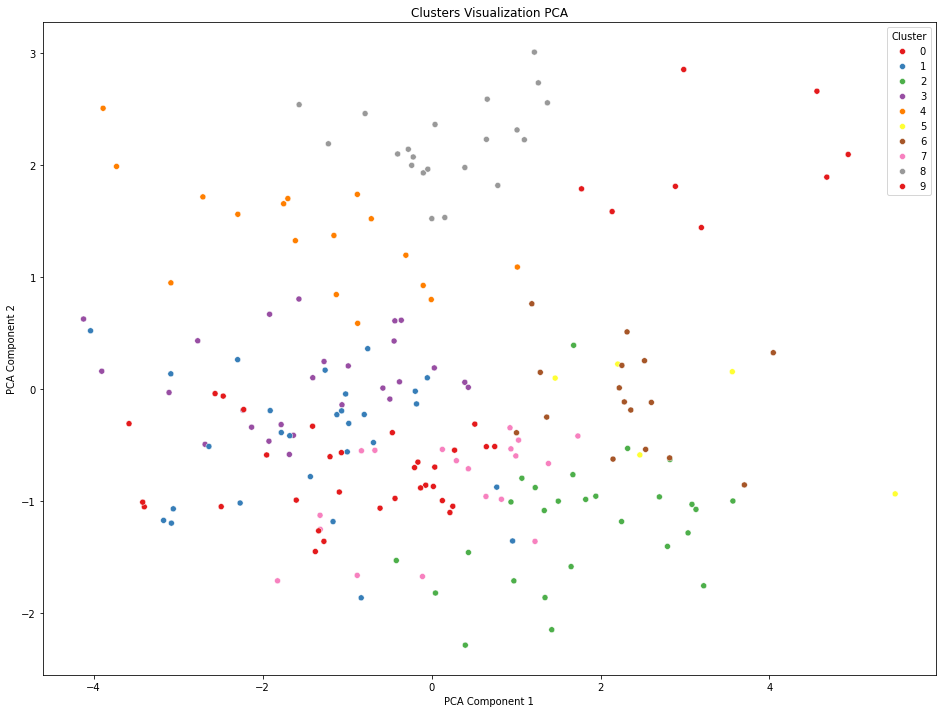

In [60]:
pca_visual = PCA(n_components=2)
pca_visual_data = pca_visual.fit_transform(scaled_data)

plt.figure(figsize=(16, 12))
sns.scatterplot(x=pca_visual_data[:, 0], y=pca_visual_data[:, 1], hue=data['Cluster'], palette='Set1')
plt.title("Clusters Visualization PCA")
plt.xlabel('PCA Component 1')
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

In [51]:
kmeans_db_scores = []
kmeans_silhouette_scores = []
kmeans_calinski_harabasz_scores_list = []  # Renamed to avoid conflict

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    db_score = davies_bouldin_score(scaled_data, cluster_labels)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    calinski_harabasz_avg = calinski_harabasz_score(scaled_data, cluster_labels)
    kmeans_db_scores.append(db_score)
    kmeans_silhouette_scores.append(silhouette_avg)
    kmeans_calinski_harabasz_scores_list.append(calinski_harabasz_avg)

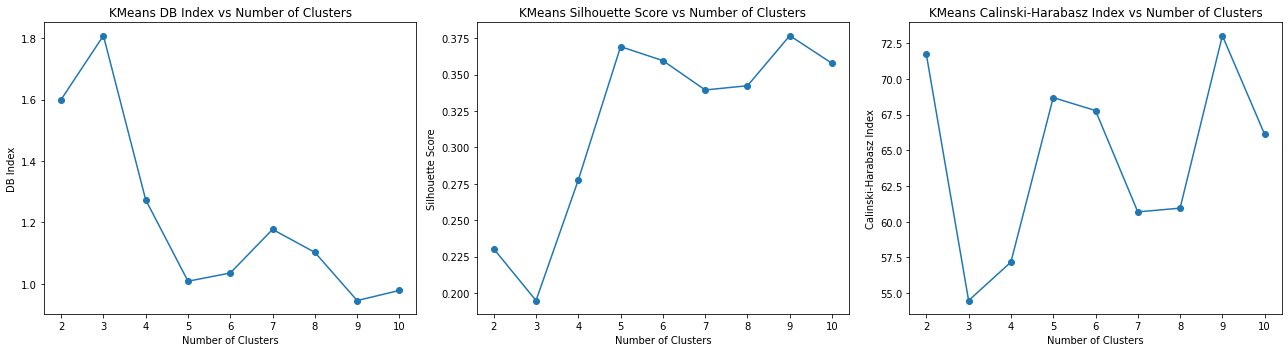

Cluster range : range(2, 11)
Kmeans db scores = [1.6000249246331681, 1.8081085398807495, 1.2736001034340774, 1.0087180296821647, 1.0354473903212857, 1.1774426921640875, 1.102530994961898, 0.9457699587105142, 0.978811394319167]
Kmeans Silhouette score : [0.2303122963685663, 0.19474342422125057, 0.2776323503292061, 0.3692498921719356, 0.3596250053789247, 0.3394663090987674, 0.34237538781582705, 0.3767976327189562, 0.3577370105952702]
kmeans calinski score list : [71.72251400226168, 54.48484174301424, 57.17749300844218, 68.68970198614433, 67.7800524722837, 60.689544333666966, 60.951642092343256, 73.02373323768333, 66.11171552503606]


In [56]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(cluster_range, kmeans_db_scores, marker='o')
plt.title("KMeans DB Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("DB Index")

plt.subplot(1, 3, 2)
plt.plot(cluster_range, kmeans_silhouette_scores, marker='o')
plt.title("KMeans Silhouette Score vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

plt.subplot(1, 3, 3)
plt.plot(cluster_range, kmeans_calinski_harabasz_scores_list, marker='o')
plt.title("KMeans Calinski-Harabasz Index vs Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Calinski-Harabasz Index")

plt.tight_layout()
plt.show()

print(f"Cluster range : {cluster_range}")
print(f"Kmeans db scores = {kmeans_db_scores}")
print(f"Kmeans Silhouette score : {kmeans_silhouette_scores}")
print(f"kmeans calinski score list : {kmeans_calinski_harabasz_scores_list}")


In [53]:
optimal_kmeans_clusters = cluster_range[np.argmin(kmeans_db_scores)]
kmeans = KMeans(n_clusters=optimal_kmeans_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)
data['KMeans_Cluster'] = cluster_labels

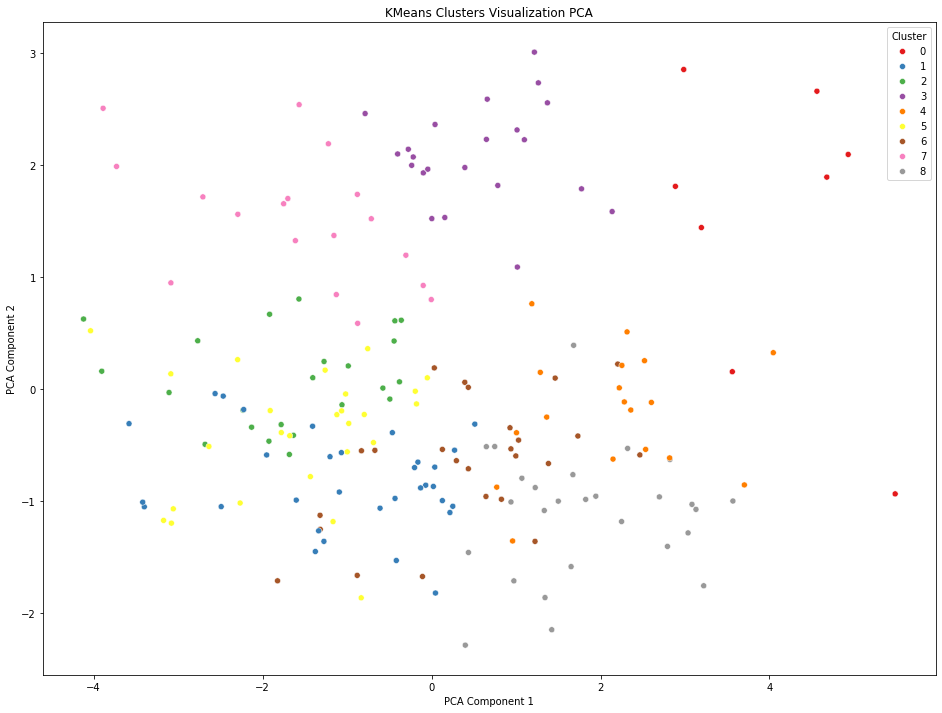

In [59]:
pca_visual_kmeans = PCA(n_components=2)
pca_visual_kmeans_data = pca_visual_kmeans.fit_transform(scaled_data)
plt.figure(figsize=(16, 12))
sns.scatterplot(x=pca_visual_kmeans_data[:, 0], y=pca_visual_kmeans_data[:, 1], hue=data['KMeans_Cluster'], palette='Set1')
plt.title("KMeans Clusters Visualization PCA")
plt.xlabel('PCA Component 1')
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

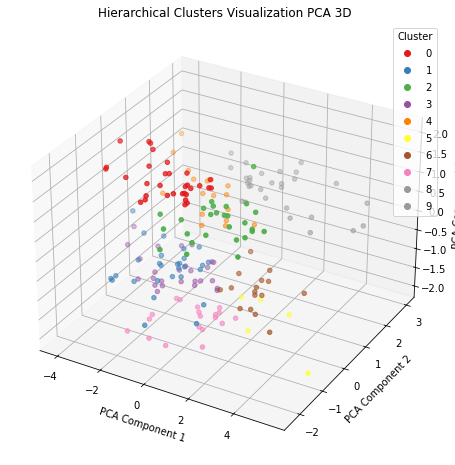

In [63]:
from mpl_toolkits.mplot3d import Axes3D

# PCA for 3D visualization
pca_visual_3d = PCA(n_components=3)
pca_visual_3d_data = pca_visual_3d.fit_transform(scaled_data)

# Visualize clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(pca_visual_3d_data[:, 0], pca_visual_3d_data[:, 1], pca_visual_3d_data[:, 2], c=data['Cluster'], cmap='Set1')
plt.title("Hierarchical Clusters Visualization PCA 3D")
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.legend(*sc.legend_elements(), title='Cluster')
plt.show()
